<img src="https://raw.githubusercontent.com/ORMIRcommunity/templates/main/images/logo_notebook.png" alt="ormir_logo" width="700" >

# Comparing methods to calculate thickness using synthetic data

- By: [Serena Bonaretti](https://sbonaretti.github.io/), [Nathan Neeteson](https://www.linkedin.com/in/nathan-neeteson-6691545b/?originalSubdomain=ca), [Sarah Manske](https://cumming.ucalgary.ca/departments/radiology/profiles/sarah-manske), started December 23, 2022 
- Code license: GNU-GPL v3
- Narrative license: CC-BY-NC-SA
- How to cite: *TBD*

---
# Aims

- In this notebook, we aim to compare various methods for thickness calculation using toy examples. Specifically:  
  [1. Creating shapes](#shapes): Creating binary images containing shapes that are simplified representations of bone and/or cartilage anatomy, and chaining the images in a 4D numpy array  
  [2. Computing thickness](#compute_th): Looping through the 4D array to calculate thickness using different methods   
  [3. Comparing thickness](#compare_th): Collecting thicknesses in a pandas dataframe for comparison     

- Notes about shapes:
  1. Each shape represents a bone anatomy/tissue:
  |Shape |Anatomy |
  |---|---|
  |hollow sphere| cortical bone in femoral head
  |hollow cylinder|cortical bone in a shaft (half cylinder cut along vertical axis could be femoral cartilage)| 
  |full cylinder | trabecular rod|
  |short full cylinder | subchondral bone in proximal tibia / tibial cartilage|
  |plate | trabecular plate|

  2. Nearly all shapes are **fully contained in the image matrix**, that is, they do not intersect the image boundaries. This is because the minimum of the local thickness field will always be less than the actual thickness of the structure if the mask intersects the boundaries of the image, because at those corners at the image boundary the spheres that fit get smaller (Issue discussed in the paper 1997_Hildebrand [[1]](#1)):
  ![](figures/1997_hildebrand.png)

  3. There are currently 5 shapes with **fixed radius**. In the next steps, we can add more shapes with changing dimensions, or less regular shapes (e.g. shape composed of 2 cylinders next to each other, each with with a different radius)

---

- Downloads and installations (to be executed only the first time):

- Downloading the `main` branch from `ORMIR_XCT`:  

In [1]:
# !# clone the folder locally
# !git clone -b main https://github.com/SpectraCollab/ORMIR_XCT.git
# !# change folder name by adding branch name as suffix
# !mv ORMIR_XCT ORMIR_XCT_main
# renaming internal folder to import the function calc_structure_thickness_statistics from the correct branch
# ! mv ORMIR_XCT_main/ormir_xct ORMIR_XCT_main/ormir_xct_main

- Downloading the `nathan/fix-dt-maybe` branch from `ORMIR_XCT`:  

In [2]:
# !# clone the folder locally
# !git clone -b nathan/fix-dt-maybe --single-branch https://github.com/SpectraCollab/ORMIR_XCT.git
# !# change folder name by adding branch name as suffix
# !mv ORMIR_XCT ORMIR_XCT_fix-dt-maybe
# renaming internal folder to import the function calc_structure_thickness_statistics from the correct branch
# ! mv ORMIR_XCT_fix-dt-maybe/ormir_xct ORMIR_XCT_fix-dt-maybe/ormir_xct_fix_dt_maybe

- Installing `ITKBoneMorphometry`:

In [3]:
# ! pip install --upgrade pip
# ! pip install itk-bonemorphometry

---

- Imports: 

In [4]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import SimpleITK as sitk
import itk 

- Importing functions from code from `ORMIR_XCT_main` and `ORMIR_XCT_fix-dt-maybe`:

In [5]:
sys.path.append("./ORMIR_XCT_main")
from ormir_xct_main.util.hildebrand_thickness import (
    calc_structure_thickness_statistics as main_calc_structure_thickness_statistics
)

In [6]:
sys.path.append("./ORMIR_XCT_fix-dt-maybe")
from ormir_xct_fix_dt_maybe.util.hildebrand_thickness import ( 
    calc_structure_thickness_statistics as branch_calc_structure_thickness_statistics
)

- Functions:

In [7]:
def create_shape(shape, voxel_widths, thickness, shape_type="sphere"):
    
    """
    Given image size, voxel size, figure thickness, and  type of shape, it returns a binary image with the input characteristics  
    This function is from the notebook: https://github.com/SpectraCollab/ORMIR_XCT/blob/main/examples/hildebrand_notebook.ipynb

    Parameters
    ----------
    shape: tuple
        Contains three numbers corresponding to image size (e.g. (25,25,25)). Unit it voxel
    voxel_widths: tuple
        Contains three numbers corresponding to voxel size (e.g. (0.0607, 0.0607, 0.0607) for HR-pQCT)
    thickness: integer
        Thickness of the figure (e.g. sphere or cylinder radius)
    shape_type: string
        It can be sphere, cylinder, plate
        
        
    Returns 
    -------
    mask: 3D numpy array
        Binary image where the shape is represented by 1s and the background by 0s
    """
    
    center = (
        voxel_widths[0] * (shape[0] // 2), 
        voxel_widths[1] * (shape[1] // 2), 
        voxel_widths[2] * (shape[2] // 2)
    )
    
    x, y, z = np.meshgrid(*[voxel_widths[i] * np.arange(0, shape[i]) for i in range(3)], indexing="ij")
    if shape_type == "sphere":
        mask = (((x-center[0])**2 + (y-center[1])**2 + (z-center[2])**2) < (thickness/2)**2).astype(int)
    elif shape_type == "cylinder":
        mask = (((x-center[0])**2 + (y-center[1])**2) < (thickness/2)**2).astype(int)
    elif shape_type == "plate":
        mask = (np.abs(x-center[0]) < thickness/2).astype(int)
    else:
        raise ValueError(f"`shape_type` can be `sphere`, `cylinder`, `plate`; got {shape_type}")
    return mask


In [8]:
def show_shape(img):
    
    """
    Given a 3D array, it imshows each slice using matplotlib
    
    Parameters
    ----------
    img: 3D numpy array
        Image to be shown
    """
    
    plt.rcParams['figure.figsize'] = [30, 2]
    fig, ax = plt.subplots(1, int(img.shape[2]/2)+1)
    
    # plot the first half
    for i in range (0, int(img.shape[2]/2)+1):
        # leave the last plot empty
        if i == int(img.shape[2]/2):
            ax[i].axis("off");
        else:
            ax[i].imshow(img[:,:,i], "gray"); ax[i].axis("off"); ax[i].set_title("slice " + str(i))
    # plot the second half
    fig, ax = plt.subplots(1, int(img.shape[2]/2)+1)
    for i in range (int(img.shape[2]/2), img.shape[2]):
        ax[i-int(img.shape[2]/2)].imshow(img[:,:,i], "gray"); ax[i-int(img.shape[2]/2)].axis("off"); ax[i-int(img.shape[2]/2)].set_title("slice " + str(i))
    

- Variables and constants:

In [9]:
# image dimension and spacing
IMAGE_SHAPE = tuple([25]*3) # image size
VOXEL_WIDTH = tuple([1]*3) # spacing 1x1x1 for simplicity

outer_radius = 17
inner_radius = 15

---
<a name="shapes"></a>
## 1. Creating shapes

### 1.1 Hollow sphere 

- Model of **cortical bone** in a **femoral head**

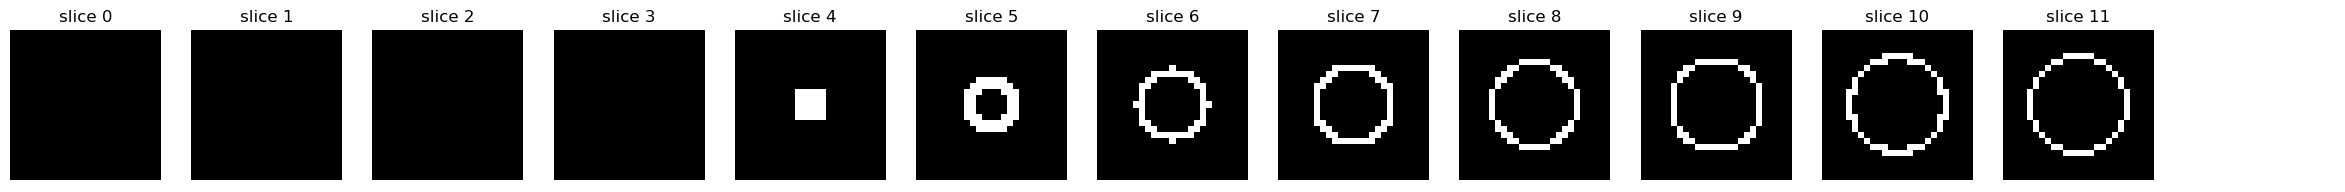

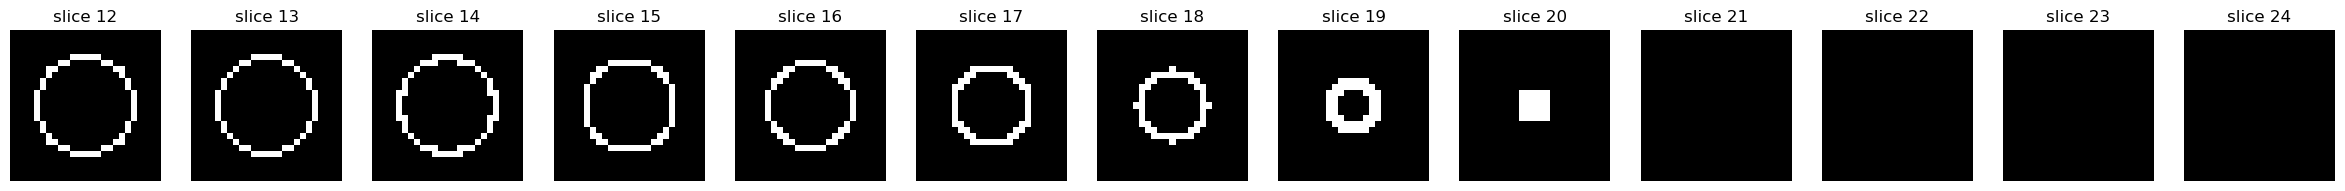

In [10]:
# creating a hollow sphere as the difference between a larger outer sphere and a smaller inner sphere
outer_sphere  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, outer_radius, shape_type="sphere")
inner_sphere  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, inner_radius, shape_type="sphere")
hollow_sphere = outer_sphere - inner_sphere

show_shape (hollow_sphere)

### 1.2 Hollow cylinder 

- Model of **cortical bone** in a **shaft**. Half cylinder cut along the axis can be the model of **femoral cartilage** 
- Note: The cylinder occupies the whole image, that is, the image has no black padding at the top nor bottom

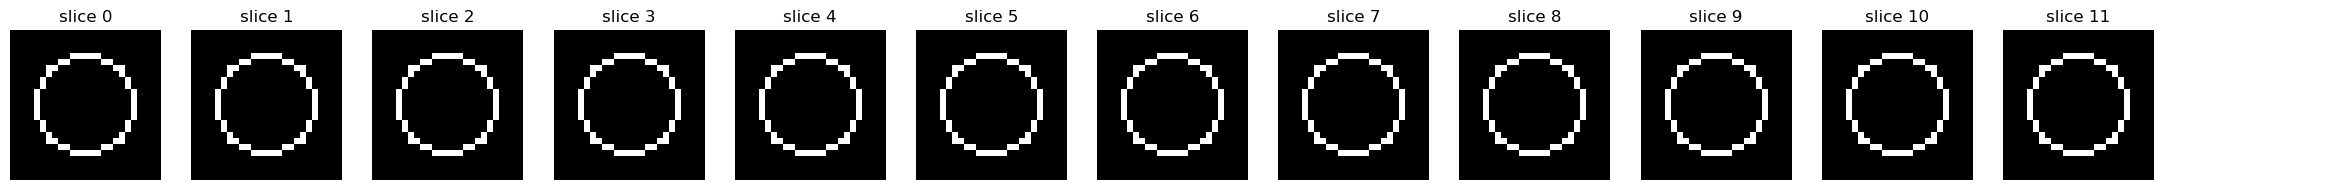

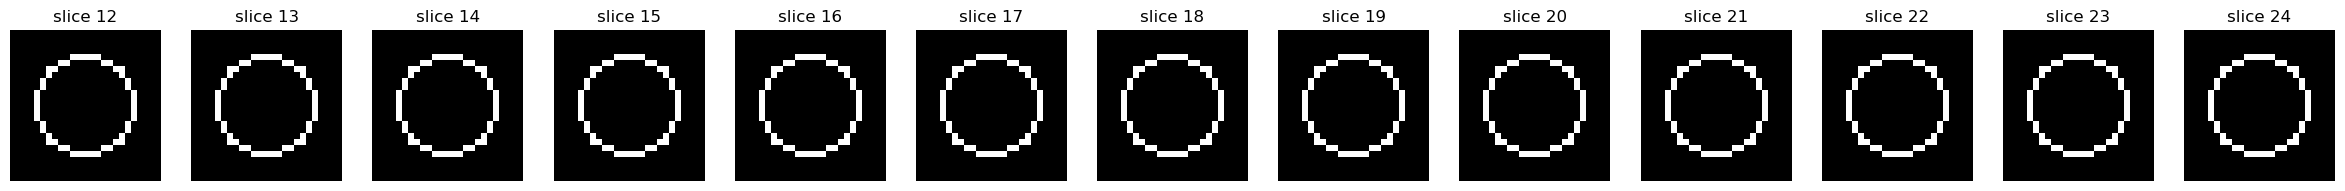

In [11]:
# creating a hollow cylinder as the difference between a larger outer cylinder and a smaller inner cylinder
outer_cylinder  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, outer_radius, shape_type="cylinder")
inner_cylinder  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, inner_radius, shape_type="cylinder")
hollow_cylinder = outer_cylinder - inner_cylinder

show_shape (hollow_cylinder)

### 1.3 Full cylinder

- Model of a **trabecular rod**
- Note: The cylinder is fully contained in the image

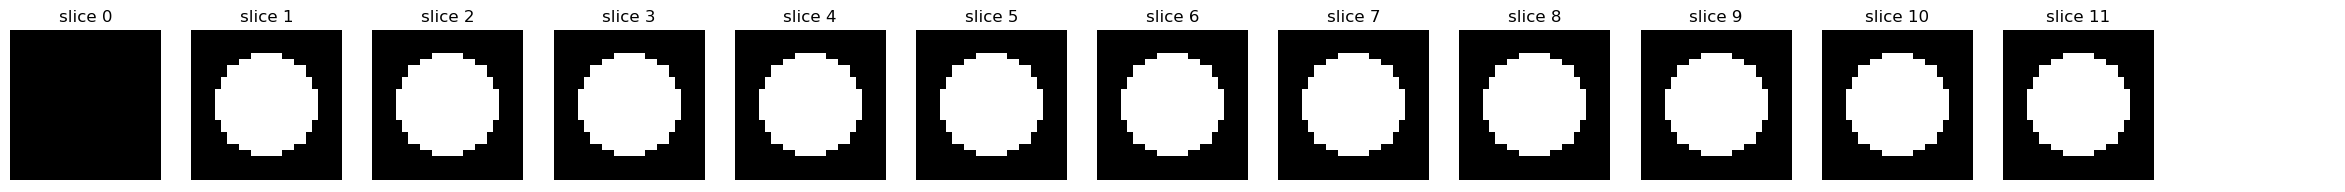

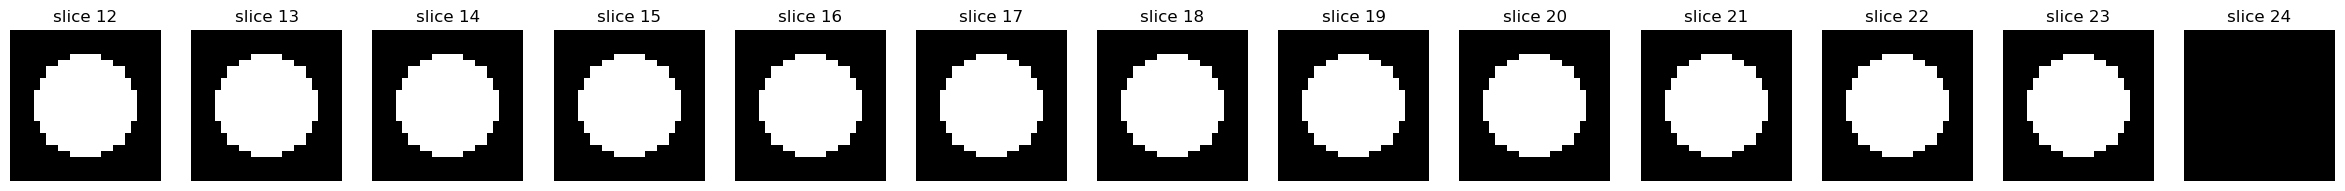

In [12]:
full_cylinder  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, outer_radius, shape_type="cylinder")
# make first and last slice black
full_cylinder[:,:,0] = np.zeros((full_cylinder.shape[0], full_cylinder.shape[1]))
full_cylinder[:,:,-1] = np.zeros((full_cylinder.shape[0], full_cylinder.shape[1]))

show_shape (full_cylinder)

In [13]:
# # to calculate the number of pixels in the full cylinder
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.imshow(full_cylinder[:,:,3])
# start = 3
# for i in range (start, 20):
#     plt.axvline(x = i+0.5, color = 'r')
#     plt.annotate(i-start+1, xy=(i+0.5, 3), color = "w", fontsize = 9 )

### 1.4 Short full cylinder 

- Model of cropped **subchondral bone in distal femur / proximal tibia** or of **tibial cartilage**

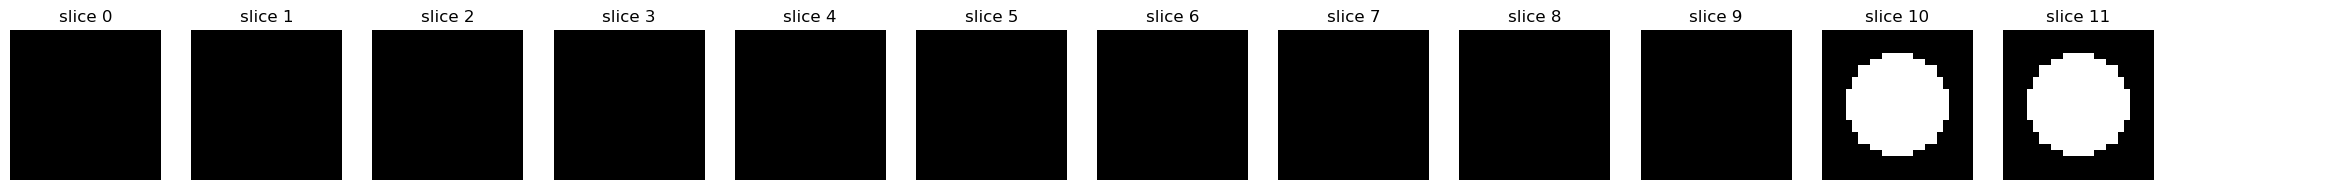

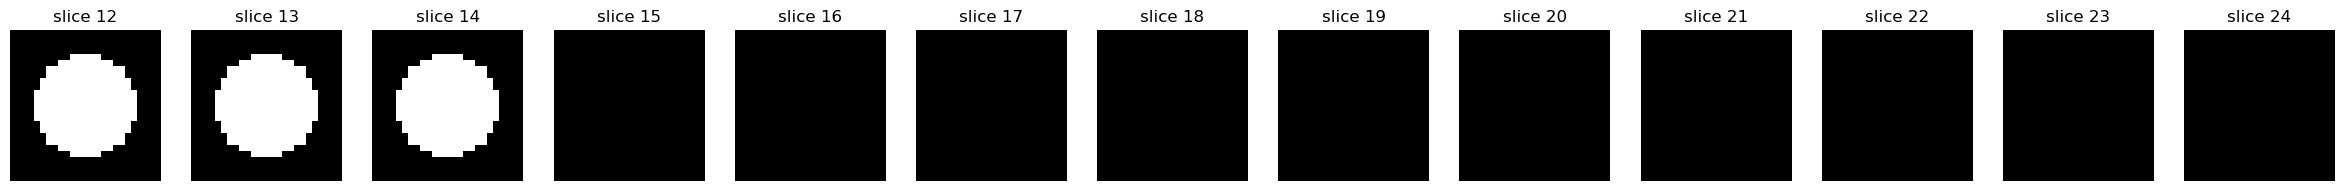

In [14]:
short_cylinder  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, outer_radius, shape_type="cylinder")
# make first and last slice black
padding = 10
short_cylinder[:,:,0:padding] = np.zeros((short_cylinder.shape[0], short_cylinder.shape[1], padding))
short_cylinder[:,:,short_cylinder.shape[2]-padding:] = np.zeros((short_cylinder.shape[0], short_cylinder.shape[1], padding))

show_shape (short_cylinder)

### 1.5 Plate 

- Model of **trabecular plate**

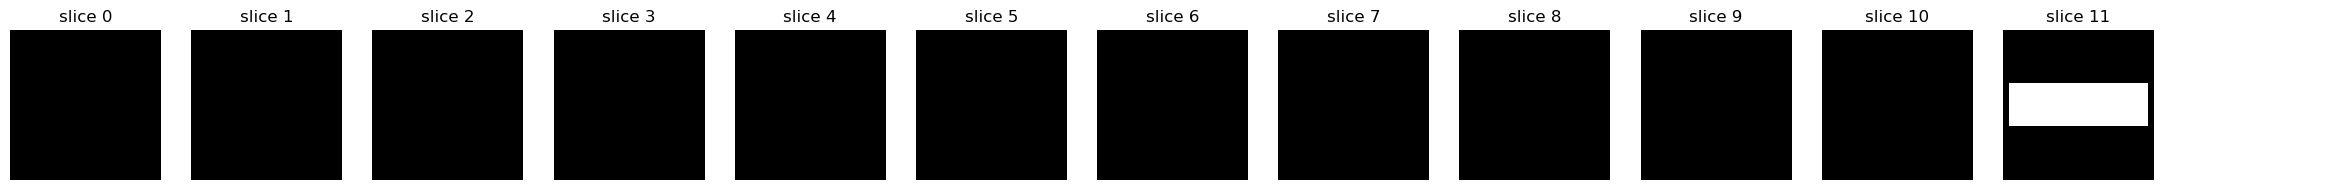

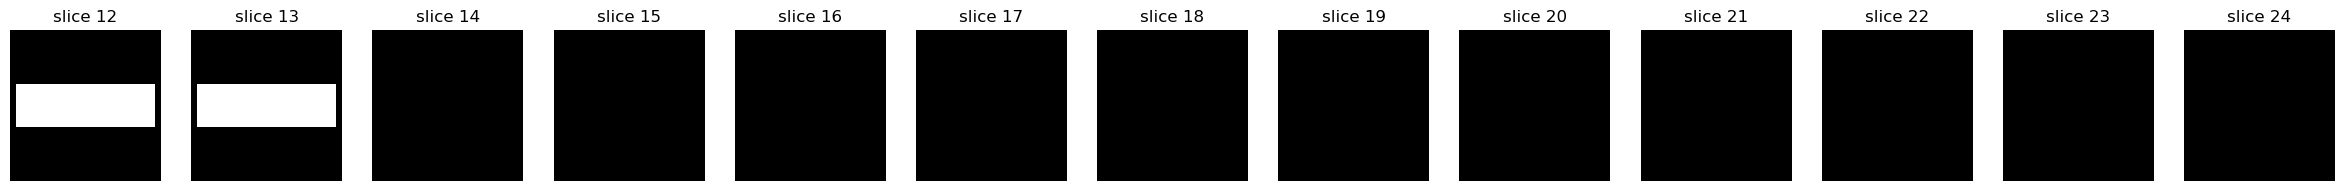

In [15]:
plate  = create_shape(IMAGE_SHAPE, VOXEL_WIDTH, 8, shape_type="plate")

# padding to include the whole plate in the figure
padding = 11
plate[:,:,0:padding] = np.zeros((plate.shape[0], plate.shape[1], padding))
plate[:,:,plate.shape[2]-padding:] = np.zeros((plate.shape[0], plate.shape[1], padding))
plate[:,0,:] = np.zeros((plate.shape[0], plate.shape[1]))
plate[:,-1,:] = np.zeros((plate.shape[0], plate.shape[1]))

show_shape (plate)

- Combining shapes into a numpy tensor for the following for loop:

In [16]:
shapes = np.stack((hollow_sphere, hollow_cylinder, full_cylinder, short_cylinder, plate), axis=3)
print ("The dimensions of the tensor are: " + str(shapes.shape))

The dimensions of the tensor are: (25, 25, 25, 5)


---
<a name="compute_th"></a>
## 2. Computing thickness

- Methods:
  - ormir_xct main branch: https://github.com/SpectraCollab/ORMIR_XCT  
    It uses the SimpleITK Meurer transform  
  - ormir fix-dt-maybe branch: https://github.com/SpectraCollab/ORMIR_XCT/blob/nathan/fix-dt-maybe/ormir_xct/util/hildebrand_thickness.py
    It oversamples the mask, uses the Euclidean DT from Scipy, then downsamples to the original resolution
  - ITK Bone morphology [[2]](#2): https://github.com/InsightSoftwareConsortium/ITKBoneMorphometry

In [17]:
# initializing dictionary containing statistics for each metric. It will become the pandas dataframe
thicknesses = {}

# for each shape in the 4D array    
for i in range (0,(shapes.shape[3])):
    
    # extract the current shape
    shape = shapes[:,:,:,i]
    
    # --- ORMIR_XCT_main ---
    thickness_stats = main_calc_structure_thickness_statistics(shape, (1,1,1), 1)
    thicknesses["ormir_xct_main"] = thicknesses.get("ormir_xct_main", []) + [thickness_stats[0]]
    # thicknesses["ormir_xct_main_std"] = thicknesses.get("ormir_xct_main_std",   []) + [thickness_stats[1]]
    # thicknesses["ormir_xct_main_min"] = thicknesses.get("ormir_xct_main_min",   []) + [thickness_stats[2]]
    # thicknesses["ormir_xct_main_max"] = thicknesses.get("ormir_xct_main_max",   []) + [thickness_stats[3]]

    # --- ORMIR_XCT_branch  ---
    thickness_stats = branch_calc_structure_thickness_statistics(shape, (1,1,1), 1)
    thicknesses["ormir_xct_branch"] = thicknesses.get("ormir_xct_branch", []) + [thickness_stats[0]]
    # thicknesses["ormir_xct_branch_std"] = thicknesses.get("ormir_xct_branch_std",   []) + [thickness_stats[1]]
    # thicknesses["ormir_xct_branch_min"] = thicknesses.get("ormir_xct_branch_min",   []) + [thickness_stats[2]]
    # thicknesses["ormir_xct_branch_max"] = thicknesses.get("ormir_xct_branch_max",   []) + [thickness_stats[3]]
    
    # --- ITKBoneMorphometry  ---
    shape = shape.astype(np.int32) # not sure about this and the following datatype conversions, but it works
    filtr = itk.BoneMorphometryFeaturesFilter.New(itk.GetImageFromArray(shape).astype(itk.UC)) #itk.UC == np.uint8 
    filtr.SetMaskImage(itk.GetImageFromArray(shape).astype(itk.UC))
    filtr.SetThreshold(1)
    filtr.Update()
    thickness = filtr.GetTbTh()
    thicknesses["itk_bone_morphometry"] = thicknesses.get("itk_bone_morphometry", []) + [thickness]


---
<a name="compare_th"></a>
## 3. Comparing thickness

In [18]:
# create dataframe from dictionary of thicknesses
df = pd.DataFrame (thicknesses)

# change the row names
shape_names = ["hollow sphere", "hollow cylinder", "full cylinder", "short full cylinder", "plate"]
df.index = shape_names

# expected values 
expected_values = [1.00, 1.00, 17.00, 5.00, 3.00]
df.insert(0, "expected", expected_values, True)
# expected IPL values (manually inserted because separately calculated)
ipl_values = [2.0000, 2.0000, 16, 5, 3]
df.insert(1, "IPL", ipl_values, True)

# show table
print ("-> The following are mean values: ")
df= df.round(decimals=2) # show only 2 decimals
df

-> The following are mean values: 


,expected,IPL,ormir_xct_main,ormir_xct_branch,itk_bone_morphometry
hollow sphere,1.0,2.0,2.00,1.00,0.95
hollow cylinder,1.0,2.0,2.00,1.00,1.09
full cylinder,17.0,16.0,15.69,13.20,7.71
short full cylinder,5.0,5.0,5.82,4.63,4.27
plate,3.0,3.0,4.00,2.98,2.89


---
## Dependencies


In [19]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2023-01-20T09:47:21.556276+01:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.5.2
pandas    : 1.4.4
SimpleITK : 2.2.1
sys       : 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy     : 1.21.5
itk       : 5.3.0



---
<a name="ref"></a>
## References

<a name="1"></a>
1. Hildebrand T. and Rüegsegger P. [A new method for the model‐independent assessment of thickness in three‐dimensional images](https://doi.org/10.1046/j.1365-2818.1997.1340694.x). Journal of microscopy 185.1 (1997): 67-75.  
<a name="2"></a>
2. Vimort J., McCormick M., Paniagua B. [Computing Bone Morphometric Feature Maps from 3-Dimensional Images](https://www.insight-journal.org/browse/publication/988). The Insight Journal. January-December. 2017.

Notebook created using the [ORMIR community](https://ormircommunity.github.io/) template (version 1.0, 2023)